Estudiante: Maldonado Aguilar Angel Julian.

In [46]:
# Librerias a utilizar.
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

## Análisis exploratorio

In [47]:
# Carga de datos.
dat = pd.read_csv("diabetes-dataset.csv")
# Visualización de las primeras 5 observaciones.
dat.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


Resumen de algunas medidas estadisticas por cada variable.

In [48]:
dat.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


Boxplot de cada predictor.

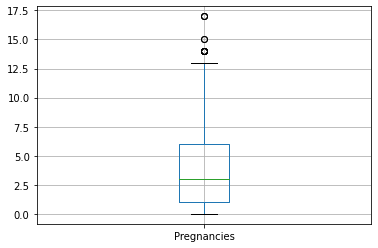

In [49]:
dat.boxplot('Pregnancies')

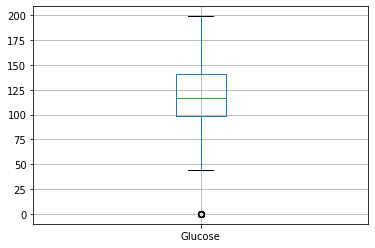

In [50]:
dat.boxplot('Glucose')

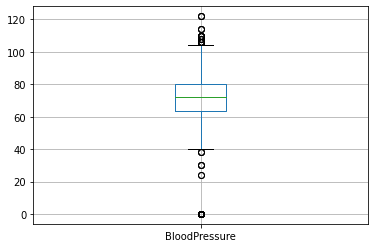

In [51]:
dat.boxplot('BloodPressure')

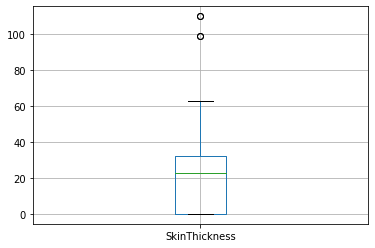

In [52]:
dat.boxplot('SkinThickness')

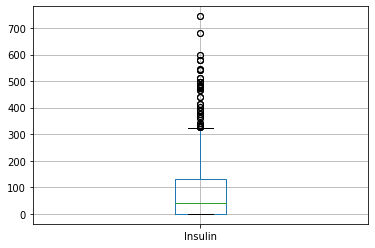

In [53]:
dat.boxplot('Insulin')

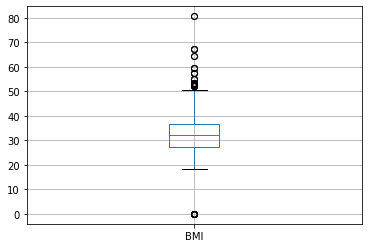

In [54]:
dat.boxplot('BMI')

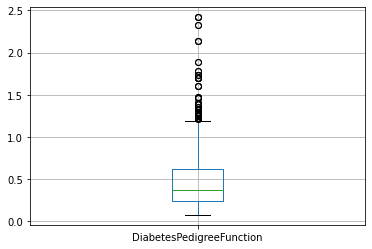

In [55]:
dat.boxplot('DiabetesPedigreeFunction')

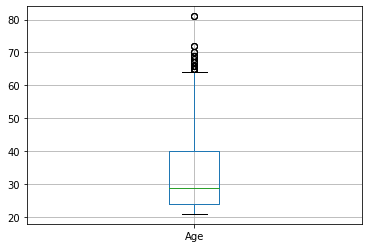

In [56]:
dat.boxplot('Age')

## 1. Separacion de conjuntos.


Se separan las predictores y la variable de respuesta asignandose a las variables **X** y **y** respectivamente.

In [57]:
X = dat.drop('Outcome', axis=1).values
y = dat['Outcome'].values

Se crea un conjunto de pruebas con el 30% de las observaciones y un conjunto de entrenamiento con el resto de observaciones, quedandose con el 70% del conjunto original.

Con *stratify=y* se consigue que la proporción de frecuencias en la variable de respuesta se mantenga en ambos conjuntos de datos (entrenamiento y prueba).

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size = 0.30, random_state = 100, stratify=y)

## 2. Adaboost

El método de ensamble Adaboost (Adaptive Boosting) es una versión extendida del método Boosting, en donde la caracteristica que tienen ambos métodos es que se crean varios estimadores de un mismo tipo, los cuales son dependientes, ya que cada estimador se construye a partir de la información de los estimadores previos enfocandose en mejorar la estimación de los errores del modelo previo. 

La particularidad de Adaboost es que cada instancia del conjunto de entrenamiento tiene un peso, inicialmente es el mismo para todos y conforme se vaya entrenando el modelo se actualizan los pesos asignandole mas importancia a aquellas instancias que fueron mal clasificadas. 

AdaBoost es regularmente utilizado para mejorar el rendimiento de los Arboles de Decisión en problemas de clasificación binaria. En scikit-learn el estimador base que utiliza por defecto para este método de ensamble es precisamente el Arbol de Decisión. 



En Adaboost es común utilizar un Arbol de Decisión que solo tiene 1 nodo y 2 hojas al cual se le conoce también como "stump", esta configuración hace que la profundidad del arbol sea de 1, sin embargo este ultimo hiperparametro se pondra a prueba para distintos valores utilizando la validación cruzada con el objetivo de ver si es posible conseguir un mejor resultado con una profundidad mayor.




In [59]:
# Se instancia el clasificador de Arbol de Decisión que se usara para la CV.
dt_estimator = DecisionTreeClassifier()

# Valores de profundidad que se pondran a prueba.
param_grid = { 'max_depth': np.arange(1,10) }
# Se realiza la validación cruzada, utilizando 5 pliegues.
dt_cv = GridSearchCV(dt_estimator, param_grid, cv = 5, scoring='accuracy')

# Se realiza el ajuste con los datos de entrenamiento.
dt_cv.fit(X_train, y_train)

print(dt_cv.best_params_) # Mejor número de profundidad.
print(dt_cv.best_score_)  # Mejor puntaje de exactitud.

{'max_depth': 9}
0.8671428571428571


Utilizando el mejor valor para la profundidad obtenido, se instancia el Arbol de Decisión que se utilizará en el método Adaboost.

In [60]:
dt = DecisionTreeClassifier(max_depth=9)

Nuevamente haciendo uso de la validación cruzada se pondra a prueba ahora la cantidad de estimadores (Arboles de Decisión) que serán utilizados por el método Adaboost.

In [61]:
# Se instancia el clasificador Adaboost que se usara para la CV.
ada_estimator = AdaBoostClassifier(base_estimator=dt)

# Valores para la cantidad de estimadores que se pondran a prueba.
param_grid = { 'n_estimators': np.arange(25, 401, 25) }
# Se realiza la validación cruzada, utilizando 5 pliegues.
ada_cv = GridSearchCV(ada_estimator, param_grid, cv = 5, scoring='accuracy')

# Se realiza el ajuste con los datos de entrenamiento.
ada_cv.fit(X_train, y_train)

print(ada_cv.best_params_) # Mejor número de estimadores.
print(ada_cv.best_score_)  # Mejor puntaje de exactitud.

{'n_estimators': 125}
0.9421428571428573


Con el mejor valor para la cantidad de estimadores ya podemos crear el clasificador final.

In [67]:
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=125)

In [68]:
# Se ajusta el modelo Adaboost utilizando el conjunto de entrenamiento.
ada.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=9),
                   n_estimators=125)

## 3. Evaluación



Con los datos de prueba separados al inicio, en la siguiente celda de código se predice la respuesta utilizando el clasificador Adaboost y se crea la matriz de confusión que nos brinda información para evaluar el modelo.

In [69]:
y_pred = ada.predict(X_test)

cm = confusion_matrix(y_test, y_pred) # [[TN, FP], [FN, TP]] 
print(cm)
print(classification_report(y_test, y_pred))

[[384  11]
 [ 12 193]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       395
           1       0.95      0.94      0.94       205

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



A continuación se evalua la exactitud, precisión, sensibilidad y la especificidad del modelo sobre los datos de prueba de manera manual, si bien el reporte de clasificación ya nos brinda algunas métricas falta la Especificidad, ademas con la siguiente evaluación podemos corroborar los resultados.

In [70]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

accuracy = (TP+TN) / (TP+TN+FP+FN)
precision = TP / (TP + FP)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Exactitud:\t", round(accuracy, 2))
print("Precisión:\t", round(precision, 2))
print("Sensibilidad:\t", round(sensitivity, 2))
print("Especificidad:\t", round(specificity, 2))

Exactitud:	 0.96
Precisión:	 0.95
Sensibilidad:	 0.94
Especificidad:	 0.97


Como el objetivo es predecir si un paciente tiene diabetes, la medida más importante es la sensibilidad, porque si bien es posible alertar a un paciente al avisarle que tiene diabetes cuando en realidad no la tiene, es preferible eso a no detectar a los pacientes que si la tienen.